<a href="https://colab.research.google.com/github/sebkplor/167-Class-Github-Repository/blob/main/project_CSCI167.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project: Deep Learning Focus

The Datasets that I have chosen are **Cifar100** and **Tiny Imagenet** because I wanted to focus on visual datasets that focused on images. Therefore I chose the two recommended inside of the project prompt.

As for the chosen Architecture, **Resnet18** and **Vision Transformer**, I asked Chat fo the recommended database that suit the two chosen datasets.


In [ ]:
!pip install -q timm datasets

import os
import math
import random
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models
import timm  # for DeiT and other modern models

from tqdm.auto import tqdm

from datasets import load_dataset  # NEW
from PIL import Image             # NEW (for safety if needed)


#Config: Class

This holds the the parameters for the datasets along with default values.

In [ ]:
@dataclass
class Config:
    dataset: str = "cifar100"
    data_root: str = "./data"
    tiny_imagenet_root: str = "./tiny-imagenet-200"
    model_name: str = "resnet18"
    pretrained: bool = True
    batch_size: int = 128
    num_workers: int = 0
    epochs: int = 200
    base_lr: float = 0.1
    weight_decay: float = 5e-4
    optimizer_type: str = "sgd"
    warmup_epochs: int = 5
    min_lr: float = 1e-5
    use_mixup: bool = False
    mixup_alpha: float = 0.2
    use_cutmix: bool = False
    cutmix_alpha: float = 1.0
    device: str = "cuda" if torch.cuda.is_available() else "cpu"


##Dataset Helpers

In [ ]:
def get_num_classes_and_img_size(cfg: Config):
    # Decide number of classes and native image resolution
    if cfg.dataset.lower() == "cifar100":
        num_classes = 100
        native_img_size = 32
    elif cfg.dataset.lower() == "tiny_imagenet":
        num_classes = 200
        native_img_size = 64
    else:
        raise ValueError(f"Unknown dataset: {cfg.dataset}")

    # For ViT-like models (DeiT), we usually train/finetune at 224x224
    if cfg.model_name.startswith("deit"):
        img_size = 224
    else:
        img_size = native_img_size

    return num_classes, img_size, native_img_size


def get_transforms(cfg: Config, img_size: int):
    # Normalization stats
    cifar_mean = (0.5071, 0.4867, 0.4408)
    cifar_std = (0.2675, 0.2565, 0.2761)
    imagenet_mean = (0.485, 0.456, 0.406)
    imagenet_std = (0.229, 0.224, 0.225)

    if cfg.dataset.lower() == "cifar100":
        mean, std = cifar_mean, cifar_std
    else:
        mean, std = imagenet_mean, imagenet_std

    # Slightly different augmentation for small vs larger images
    if img_size >= 64:
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(img_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])
    else:
        train_tfms = transforms.Compose([
            transforms.RandomCrop(img_size, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ])

    test_tfms = transforms.Compose([
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    return train_tfms, test_tfms


class HFTinyImageNet(torch.utils.data.Dataset):
    """
    Wraps the Hugging Face `zh-plus/tiny-imagenet` split as a PyTorch Dataset,
    applying torchvision-style transforms.
    """
    def __init__(self, hf_split, transform=None):
        self.hf_split = hf_split  # e.g., dataset["train"] or ["valid"]
        self.transform = transform

    def __len__(self):
        return len(self.hf_split)

    def __getitem__(self, idx):
        example = self.hf_split[idx]
        img = example["image"]   # This is already a PIL.Image.Image
        label = example["label"] # int in [0, 199]

        # Ensure image is RGB (some Tiny-ImageNet images may be grayscale)
        if img.mode != "RGB":
            img = img.convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        return img, label


import random

def get_dataloaders(cfg: Config):
    num_classes, img_size, _ = get_num_classes_and_img_size(cfg)
    train_tfms, test_tfms = get_transforms(cfg, img_size)

    if cfg.dataset.lower() == "cifar100":
        train_set = datasets.CIFAR100(
            root=cfg.data_root,
            train=True,
            download=True,
            transform=train_tfms,
        )
        test_set = datasets.CIFAR100(
            root=cfg.data_root,
            train=False,
            download=True,
            transform=test_tfms,
        )

    elif cfg.dataset.lower() == "tiny_imagenet":
        hf_ds = load_dataset("zh-plus/tiny-imagenet")
        hf_train = hf_ds["train"]
        hf_valid = hf_ds["valid"]

        # Using the full dataset instead of a subset
        print(f"[Tiny ImageNet] Using full dataset: {len(hf_train)} training images, {len(hf_valid)} validation images")

        train_set = HFTinyImageNet(hf_train, transform=train_tfms)
        test_set = HFTinyImageNet(hf_valid, transform=test_tfms)

    else:
        raise ValueError(f"Unknown dataset: {cfg.dataset}")

    train_loader = DataLoader(
        train_set,
        batch_size=cfg.batch_size,
        shuffle=True,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=cfg.batch_size,
        shuffle=False,
        num_workers=cfg.num_workers,
        pin_memory=True,
    )

    return train_loader, test_loader, num_classes

In [ ]:
def get_model(cfg: Config, num_classes: int):
    name = cfg.model_name.lower()

    if name == "resnet18":
        model = models.resnet18(
            weights=models.ResNet18_Weights.IMAGENET1K_V1 if cfg.pretrained else None
        )
        # Replace the last fully-connected layer
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "efficientnet_b0":
        model = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1 if cfg.pretrained else None
        )
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)

    elif name == "deit_tiny":
        # from timm: "deit_tiny_patch16_224"
        model = timm.create_model(
            "deit_tiny_patch16_224",
            pretrained=cfg.pretrained,
            num_classes=num_classes,
        )
    else:
        raise ValueError(f"Unknown model_name: {cfg.model_name}")

    return model


In [ ]:
def rand_beta(alpha, device):
    if alpha <= 0:
        return 1.0
    return torch.distributions.Beta(alpha, alpha).sample().to(device)


def mixup_data(x, y, alpha, device):
    """MixUp: convex combination of two images & labels."""
    lam = rand_beta(alpha, device)
    batch_size = x.size(0)
    index = torch.randperm(batch_size, device=device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def cutmix_data(x, y, alpha, device):
    """CutMix: cut a patch from one image and paste into another."""
    lam = rand_beta(alpha, device)
    batch_size, _, h, w = x.size()
    index = torch.randperm(batch_size, device=device)

    # Random box
    cx = torch.randint(w, (1,), device=device)
    cy = torch.randint(h, (1,), device=device)
    cut_w = int(w * math.sqrt(1 - lam))
    cut_h = int(h * math.sqrt(1 - lam))

    x1 = torch.clamp(cx - cut_w // 2, 0, w)
    x2 = torch.clamp(cx + cut_w // 2, 0, w)
    y1 = torch.clamp(cy - cut_h // 2, 0, h)
    y2 = torch.clamp(cy + cut_h // 2, 0, h)

    x_mixed = x.clone()
    x_mixed[:, :, y1:y2, x1:x2] = x[index, :, y1:y2, x1:x2]

    # Adjust lambda based on actual patch area
    lam = 1 - ((x2 - x1) * (y2 - y1) / (w * h))

    y_a, y_b = y, y[index]
    return x_mixed, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """Loss for MixUp/CutMix: weighted sum of two cross-entropies."""
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


In [ ]:
def create_scheduler(optimizer, cfg: Config):
    """Cosine LR with linear warmup."""
    def lr_lambda(epoch):
        if epoch < cfg.warmup_epochs:
            # linear warmup
            return float(epoch + 1) / float(max(1, cfg.warmup_epochs))
        # cosine decay
        progress = float(epoch - cfg.warmup_epochs) / float(max(1, cfg.epochs - cfg.warmup_epochs))
        cosine = 0.5 * (1.0 + math.cos(math.pi * progress))
        return (cfg.min_lr / cfg.base_lr) + (1 - cfg.min_lr / cfg.base_lr) * cosine

    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lr_lambda)
    return scheduler


def train_one_epoch(model, loader, optimizer, scheduler, criterion, cfg: Config, epoch: int):
    model.train()
    device = cfg.device

    running_loss = 0.0
    running_correct = 0
    total = 0

    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/{cfg.epochs}", leave=False)
    for images, targets in pbar:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        # Decide if we apply MixUp/CutMix this batch
        use_mix = cfg.use_mixup and (cfg.mixup_alpha > 0)
        use_cut = cfg.use_cutmix and (cfg.cutmix_alpha > 0)

        if use_mix or use_cut:
            if use_mix and use_cut:
                # randomly pick between mixup and cutmix
                if torch.rand(1).item() < 0.5:
                    images, y_a, y_b, lam = mixup_data(images, targets, cfg.mixup_alpha, device)
                else:
                    images, y_a, y_b, lam = cutmix_data(images, targets, cfg.cutmix_alpha, device)
            elif use_mix:
                images, y_a, y_b, lam = mixup_data(images, targets, cfg.mixup_alpha, device)
            else:
                images, y_a, y_b, lam = cutmix_data(images, targets, cfg.cutmix_alpha, device)

            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, y_a, y_b, lam)
            _, preds = outputs.max(1)
            # Accuracy approximation: compare predictions to original targets
            running_correct += (preds == targets).sum().item()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            _, preds = outputs.max(1)
            running_correct += (preds == targets).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        total += images.size(0)

        pbar.set_postfix({
            "loss": f"{running_loss / total:.4f}",
            "acc": f"{100.0 * running_correct / total:.2f}%"
        })

    if scheduler is not None:
        scheduler.step()

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * running_correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, loader, criterion, cfg: Config):
    model.eval()
    device = cfg.device

    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        running_correct += (preds == targets).sum().item()
        total += images.size(0)

    loss_avg = running_loss / total
    acc = 100.0 * running_correct / total
    return loss_avg, acc


**Example: CIFAR-100 + ResNet-18 + SGD**

In [ ]:
cfg = Config(
    dataset="cifar100",             # "cifar100" or "tiny_imagenet"
    data_root="./data",
    tiny_imagenet_root="./tiny-imagenet-200",  # update if you use Tiny ImageNet

    model_name="resnet18",          # "resnet18", "efficientnet_b0", "deit_tiny"
    pretrained=True,

    batch_size=128,
    num_workers=0,
    epochs=50,                      # increase to 200 for final runs

    optimizer_type="sgd",           # "sgd" or "adamw"
    base_lr=0.1,                    # for SGD; if you use AdamW, try 3e-4 or 5e-4
    weight_decay=5e-4,

    warmup_epochs=5,
    min_lr=1e-5,

    use_mixup=False,
    mixup_alpha=0.2,
    use_cutmix=False,
    cutmix_alpha=1.0,
)

print(cfg)


Config(dataset='cifar100', data_root='./data', tiny_imagenet_root='./tiny-imagenet-200', model_name='resnet18', pretrained=True, batch_size=128, num_workers=0, epochs=50, base_lr=0.1, weight_decay=0.0005, optimizer_type='sgd', warmup_epochs=5, min_lr=1e-05, use_mixup=False, mixup_alpha=0.2, use_cutmix=False, cutmix_alpha=1.0, device='cuda')


In [ ]:
# Build dataloaders and model
train_loader, test_loader, num_classes = get_dataloaders(cfg)
model = get_model(cfg, num_classes=num_classes).to(cfg.device)

# Choose optimizer
if cfg.optimizer_type == "sgd":
    optimizer = optim.SGD(
        model.parameters(),
        lr=cfg.base_lr,
        momentum=0.9,
        weight_decay=cfg.weight_decay,
        nesterov=True,
    )
else:  # AdamW
    optimizer = optim.AdamW(
        model.parameters(),
        lr=cfg.base_lr,
        weight_decay=cfg.weight_decay,
    )

scheduler = create_scheduler(optimizer, cfg)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(cfg.epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, scheduler, criterion, cfg, epoch
    )
    val_loss, val_acc = evaluate(model, test_loader, criterion, cfg)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch [{epoch+1}/{cfg.epochs}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    )

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        os.makedirs("checkpoints", exist_ok=True)
        save_path = f"checkpoints/{cfg.dataset}_{cfg.model_name}_best.pth"
        torch.save(
            {
                "model_state": model.state_dict(),
                "cfg": cfg.__dict__,
                "epoch": epoch,
                "val_acc": val_acc,
            },
            save_path,
        )
        print(f"  >> New best model saved to {save_path} (acc={best_acc:.2f}%)")

print(f"Training complete. Best Val Acc: {best_acc:.2f}%")


Epoch 1/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/50] Train Loss: 2.8574 | Train Acc: 28.82% Val Loss: 2.3368 | Val Acc: 38.67%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=38.67%)


Epoch 2/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/50] Train Loss: 2.8527 | Train Acc: 28.86% Val Loss: 2.5584 | Val Acc: 34.29%


Epoch 3/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/50] Train Loss: 2.8794 | Train Acc: 28.08% Val Loss: 3.0567 | Val Acc: 26.66%


Epoch 4/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/50] Train Loss: 3.1439 | Train Acc: 23.03% Val Loss: 2.8947 | Val Acc: 28.12%


Epoch 5/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/50] Train Loss: 2.7837 | Train Acc: 29.42% Val Loss: 2.7348 | Val Acc: 31.25%


Epoch 6/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/50] Train Loss: 3.1787 | Train Acc: 22.57% Val Loss: 2.9553 | Val Acc: 26.44%


Epoch 7/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/50] Train Loss: 2.8335 | Train Acc: 28.67% Val Loss: 2.6689 | Val Acc: 32.87%


Epoch 8/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/50] Train Loss: 2.5435 | Train Acc: 34.19% Val Loss: 2.5209 | Val Acc: 35.23%


Epoch 9/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/50] Train Loss: 2.4121 | Train Acc: 36.87% Val Loss: 2.3982 | Val Acc: 38.07%


Epoch 10/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/50] Train Loss: 2.3138 | Train Acc: 38.78% Val Loss: 2.3691 | Val Acc: 38.37%


Epoch 11/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/50] Train Loss: 2.2463 | Train Acc: 40.28% Val Loss: 2.3197 | Val Acc: 38.83%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=38.83%)


Epoch 12/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/50] Train Loss: 2.1872 | Train Acc: 41.62% Val Loss: 2.2801 | Val Acc: 40.36%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=40.36%)


Epoch 13/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/50] Train Loss: 2.1322 | Train Acc: 42.52% Val Loss: 2.3343 | Val Acc: 39.53%


Epoch 14/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/50] Train Loss: 2.0858 | Train Acc: 43.89% Val Loss: 2.1778 | Val Acc: 42.86%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=42.86%)


Epoch 15/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/50] Train Loss: 2.0474 | Train Acc: 44.72% Val Loss: 2.1463 | Val Acc: 43.28%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=43.28%)


Epoch 16/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/50] Train Loss: 2.0066 | Train Acc: 45.59% Val Loss: 2.1994 | Val Acc: 42.22%


Epoch 17/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/50] Train Loss: 1.9687 | Train Acc: 46.34% Val Loss: 2.1265 | Val Acc: 43.61%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=43.61%)


Epoch 18/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/50] Train Loss: 1.9340 | Train Acc: 47.27% Val Loss: 2.0798 | Val Acc: 44.95%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=44.95%)


Epoch 19/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/50] Train Loss: 1.8960 | Train Acc: 47.97% Val Loss: 1.9752 | Val Acc: 46.95%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=46.95%)


Epoch 20/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/50] Train Loss: 1.8603 | Train Acc: 48.77% Val Loss: 2.0352 | Val Acc: 45.96%


Epoch 21/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21/50] Train Loss: 1.8290 | Train Acc: 49.82% Val Loss: 2.0158 | Val Acc: 46.66%


Epoch 22/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22/50] Train Loss: 1.7893 | Train Acc: 50.48% Val Loss: 2.0524 | Val Acc: 46.13%


Epoch 23/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23/50] Train Loss: 1.7548 | Train Acc: 51.28% Val Loss: 2.0741 | Val Acc: 45.72%


Epoch 24/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24/50] Train Loss: 1.7197 | Train Acc: 52.10% Val Loss: 2.0257 | Val Acc: 46.63%


Epoch 25/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25/50] Train Loss: 1.6766 | Train Acc: 53.21% Val Loss: 1.9662 | Val Acc: 47.84%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=47.84%)


Epoch 26/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [26/50] Train Loss: 1.6302 | Train Acc: 54.33% Val Loss: 1.9561 | Val Acc: 48.09%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=48.09%)


Epoch 27/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [27/50] Train Loss: 1.5876 | Train Acc: 55.14% Val Loss: 1.9121 | Val Acc: 49.16%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=49.16%)


Epoch 28/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [28/50] Train Loss: 1.5497 | Train Acc: 56.14% Val Loss: 1.9035 | Val Acc: 49.69%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=49.69%)


Epoch 29/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [29/50] Train Loss: 1.4998 | Train Acc: 57.45% Val Loss: 1.8562 | Val Acc: 50.96%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=50.96%)


Epoch 30/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [30/50] Train Loss: 1.4579 | Train Acc: 58.70% Val Loss: 1.7600 | Val Acc: 52.86%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=52.86%)


Epoch 31/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [31/50] Train Loss: 1.4051 | Train Acc: 59.80% Val Loss: 1.8002 | Val Acc: 52.05%


Epoch 32/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [32/50] Train Loss: 1.3506 | Train Acc: 61.01% Val Loss: 1.7990 | Val Acc: 52.19%


Epoch 33/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [33/50] Train Loss: 1.2969 | Train Acc: 62.50% Val Loss: 1.7524 | Val Acc: 54.20%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=54.20%)


Epoch 34/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [34/50] Train Loss: 1.2351 | Train Acc: 63.77% Val Loss: 1.7649 | Val Acc: 54.34%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=54.34%)


Epoch 35/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [35/50] Train Loss: 1.1767 | Train Acc: 65.43% Val Loss: 1.7515 | Val Acc: 54.31%


Epoch 36/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [36/50] Train Loss: 1.1022 | Train Acc: 67.46% Val Loss: 1.7140 | Val Acc: 55.47%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=55.47%)


Epoch 37/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [37/50] Train Loss: 1.0391 | Train Acc: 68.99% Val Loss: 1.6867 | Val Acc: 55.67%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=55.67%)


Epoch 38/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [38/50] Train Loss: 0.9598 | Train Acc: 71.45% Val Loss: 1.7229 | Val Acc: 55.79%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=55.79%)


Epoch 39/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [39/50] Train Loss: 0.8824 | Train Acc: 73.28% Val Loss: 1.6964 | Val Acc: 56.63%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=56.63%)


Epoch 40/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [40/50] Train Loss: 0.8097 | Train Acc: 75.56% Val Loss: 1.7140 | Val Acc: 56.96%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=56.96%)


Epoch 41/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [41/50] Train Loss: 0.7199 | Train Acc: 78.00% Val Loss: 1.6554 | Val Acc: 58.28%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=58.28%)


Epoch 42/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [42/50] Train Loss: 0.6386 | Train Acc: 80.70% Val Loss: 1.6763 | Val Acc: 58.39%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=58.39%)


Epoch 43/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [43/50] Train Loss: 0.5600 | Train Acc: 83.09% Val Loss: 1.6710 | Val Acc: 58.90%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=58.90%)


Epoch 44/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [44/50] Train Loss: 0.4815 | Train Acc: 85.39% Val Loss: 1.6685 | Val Acc: 59.51%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=59.51%)


Epoch 45/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [45/50] Train Loss: 0.4191 | Train Acc: 87.53% Val Loss: 1.6634 | Val Acc: 60.01%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=60.01%)


Epoch 46/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [46/50] Train Loss: 0.3637 | Train Acc: 89.55% Val Loss: 1.6728 | Val Acc: 59.91%


Epoch 47/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [47/50] Train Loss: 0.3226 | Train Acc: 91.00% Val Loss: 1.6671 | Val Acc: 60.58%
  >> New best model saved to checkpoints/cifar100_resnet18_best.pth (acc=60.58%)


Epoch 48/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [48/50] Train Loss: 0.2935 | Train Acc: 91.98% Val Loss: 1.6713 | Val Acc: 60.04%


Epoch 49/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [49/50] Train Loss: 0.2771 | Train Acc: 92.58% Val Loss: 1.6696 | Val Acc: 60.38%


Epoch 50/50:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch [50/50] Train Loss: 0.2675 | Train Acc: 92.95% Val Loss: 1.6695 | Val Acc: 60.30%
Training complete. Best Val Acc: 60.58%


**First Output from Cifar100 + Resnet18**

Note: This output is incomplete since it timed-out from connection to runtime

Epoch 1/50: 100% 391/391 [10:07<00:00,  1.41s/it, loss=2.8770, acc=28.48%]

Epoch [1/50] Train Loss: 2.8770 | Train Acc: 28.48% Val Loss: 2.3575 | Val Acc: 38.63%

Epoch 2/50: 100% 391/391 [10:10<00:00,  1.33s/it, loss=2.5495, acc=34.23%]


Epoch [2/50] Train Loss: 2.5495 | Train Acc: 34.23% Val Loss: 2.2581 | Val Acc: 41.27%
  
Epoch [3/50] Train Loss: 2.4806 | Train Acc: 35.58% Val Loss: 2.4175 | Val Acc: 38.29%

Epoch 4/50: 100% 391/391 [10:17<00:00,  1.38s/it, loss=2.6067, acc=33.13%]

Epoch [4/50] Train Loss: 2.6067 | Train Acc: 33.13% Val Loss: 2.5593 | Val Acc: 34.03%

Epoch 5/50: 100% 391/391 [09:53<00:00,  1.45s/it, loss=2.4946, acc=35.38%]

Epoch [5/50] Train Loss: 2.4946 | Train Acc: 35.38% Val Loss: 2.4441 | Val Acc: 37.13%

Epoch 6/50: 100% 391/391 [09:33<00:00,  1.35s/it, loss=2.2686, acc=40.13%]

Epoch [6/50] Train Loss: 2.2686 | Train Acc: 40.13% Val Loss: 2.2211 | Val Acc: 41.68%

Epoch 7/50: 100% 391/391 [09:45<00:00,  1.21s/it, loss=2.1453, acc=42.49%]

Epoch [7/50] Train Loss: 2.1453 | Train Acc: 42.49% Val Loss: 2.2103 | Val Acc: 41.72%

Epoch 8/50: 100% 391/391 [09:37<00:00,  1.34s/it, loss=2.1196, acc=43.08%]

Epoch [8/50] Train Loss: 2.1196 | Train Acc: 43.08% Val Loss: 2.3373 | Val Acc: 40.12%

Epoch 9/50: 100% 391/391 [09:36<00:00,  1.40s/it, loss=2.0383, acc=44.99%]

Epoch [9/50] Train Loss: 2.0383 | Train Acc: 44.99% Val Loss: 2.2795 | Val Acc: 40.89%

Epoch 10/50: 100% 391/391 [09:46<00:00,  1.47s/it, loss=2.0003, acc=46.06%]

Epoch [10/50] Train Loss: 2.0003 | Train Acc: 46.06% Val Loss: 2.2141 | Val Acc: 42.32%

Epoch 11/50: 100% 391/391 [09:39<00:00,  1.32s/it, loss=1.9630, acc=46.78%]

Epoch [11/50] Train Loss: 1.9630 | Train Acc: 46.78% Val Loss: 2.1219 | Val Acc: 44.40%

Epoch 12/50: 100% 391/391 [09:47<00:00,  1.20s/it, loss=1.9287, acc=47.25%]

Epoch [12/50] Train Loss: 1.9287 | Train Acc: 47.25% Val Loss: 2.2008 | Val Acc: 42.86%

Epoch 13/50: 100% 391/391 [10:01<00:00,  1.39s/it, loss=1.9004, acc=48.04%]

Epoch [13/50] Train Loss: 1.9004 | Train Acc: 48.04% Val Loss: 2.2661 | Val Acc: 42.69%

Epoch 14/50: 100% 391/391 [09:47<00:00,  1.22s/it, loss=1.8713, acc=48.55%]

Epoch [14/50] Train Loss: 1.8713 | Train Acc: 48.55% Val Loss: 2.1865 | Val Acc: 43.67%

Epoch 15/50: 100% 391/391 [10:01<00:00,  1.23s/it, loss=1.8405, acc=49.37%]

Epoch [15/50] Train Loss: 1.8405 | Train Acc: 49.37% Val Loss: 1.9360 | Val Acc: 47.63%

Epoch 16/50: 100% 391/391 [10:07<00:00,  1.44s/it, loss=1.8213, acc=49.92%]

Epoch [16/50] Train Loss: 1.8213 | Train Acc: 49.92% Val Loss: 2.0369 | Val Acc: 46.57%

Epoch 17/50: 100% 391/391 [09:44<00:00,  1.20s/it, loss=1.7910, acc=50.62%]

Epoch [17/50] Train Loss: 1.7910 | Train Acc: 50.62% Val Loss: 2.0443 | Val Acc: 46.13%

Epoch 18/50: 100% 391/391 [09:43<00:00,  1.44s/it, loss=1.7552, acc=51.30%]

Epoch [18/50] Train Loss: 1.7552 | Train Acc: 51.30% Val Loss: 1.9753 | Val Acc: 47.65%

Epoch 19/50: 100% 391/391 [09:45<00:00,  1.23s/it, loss=1.7346, acc=51.85%]

Epoch [19/50] Train Loss: 1.7346 | Train Acc: 51.85% Val Loss: 1.9339 | Val Acc: 48.52%

Epoch 20/50: 100% 391/391 [09:49<00:00,  1.27s/it, loss=1.7126, acc=52.47%]

Epoch [20/50] Train Loss: 1.7126 | Train Acc: 52.47% Val Loss: 1.9231 | Val Acc: 49.42%

Epoch 21/50: 100% 391/391 [09:41<00:00,  1.33s/it, loss=1.6742, acc=53.40%]

Epoch [21/50] Train Loss: 1.6742 | Train Acc: 53.40% Val Loss: 1.9429 | Val Acc: 49.08%

Epoch 22/50: 100% 391/391 [10:06<00:00,  1.43s/it, loss=1.6475, acc=54.12%]

Epoch [22/50] Train Loss: 1.6475 | Train Acc: 54.12% Val Loss: 1.8867 | Val Acc: 49.33%

Epoch 23/50: 100% 391/391 [10:14<00:00,  1.43s/it, loss=1.6023, acc=54.98%]

Epoch [23/50] Train Loss: 1.6023 | Train Acc: 54.98% Val Loss: 1.9509 | Val Acc: 48.99%

Epoch 24/50: 100% 391/391 [09:59<00:00,  1.52s/it, loss=1.5770, acc=55.57%]

Epoch [24/50] Train Loss: 1.5770 | Train Acc: 55.57% Val Loss: 1.8602 | Val Acc: 50.18%

Epoch 25/50: 100% 391/391 [09:54<00:00,  1.25s/it, loss=1.5457, acc=56.36%]

Epoch [25/50] Train Loss: 1.5457 | Train Acc: 56.36% Val Loss: 1.9076 | Val Acc: 50.19%

Epoch 26/50: 100% 391/391 [09:54<00:00,  1.42s/it, loss=1.4973, acc=57.27%]

Epoch [26/50] Train Loss: 1.4973 | Train Acc: 57.27% Val Loss: 1.9138 | Val Acc: 49.78%

Epoch 27/50: 100% 391/391 [09:59<00:00,  1.32s/it, loss=1.4667, acc=58.30%]

Epoch [27/50] Train Loss: 1.4667 | Train Acc: 58.30% Val Loss: 1.8145 | Val Acc: 51.30%

Epoch 28/50: 100% 391/391 [10:29<00:00,  1.50s/it, loss=1.4149, acc=59.55%]

Epoch [28/50] Train Loss: 1.4149 | Train Acc: 59.55% Val Loss: 1.7882 | Val Acc: 52.47%

Epoch 29/50: 100% 391/391 [09:50<00:00,  1.48s/it, loss=1.3773, acc=60.24%]

Epoch [29/50] Train Loss: 1.3773 | Train Acc: 60.24% Val Loss: 1.7898 | Val Acc: 52.26%

Epoch 30/50: 100% 391/391 [10:07<00:00,  1.64s/it, loss=1.3268, acc=61.68%]

Epoch [30/50] Train Loss: 1.3268 | Train Acc: 61.68% Val Loss: 1.7643 | Val Acc: 53.05%

Epoch 31/50: 100% 391/391 [10:01<00:00,  1.38s/it, loss=1.2814, acc=62.77%]

Epoch [31/50] Train Loss: 1.2814 | Train Acc: 62.77% Val Loss: 1.8177 | Val Acc: 52.41%

Epoch 32/50: 100% 391/391 [10:10<00:00,  1.55s/it, loss=1.2239, acc=64.34%]

Epoch [32/50] Train Loss: 1.2239 | Train Acc: 64.34% Val Loss: 1.7018 | Val Acc: 54.51%

Epoch 33/50: 100% 391/391 [10:03<00:00,  1.46s/it, loss=1.1708, acc=65.73%]

Epoch [33/50] Train Loss: 1.1708 | Train Acc: 65.73% Val Loss: 1.7006 | Val Acc: 54.93%

Epoch 34/50: 100% 391/391 [10:00<00:00,  1.39s/it, loss=1.1014, acc=67.60%]

Epoch [34/50] Train Loss: 1.1014 | Train Acc: 67.60% Val Loss: 1.6550 | Val Acc: 56.11%

Epoch 35/50: 100% 391/391 [10:09<00:00,  1.55s/it, loss=1.0499, acc=68.77%]

Epoch [35/50] Train Loss: 1.0499 | Train Acc: 68.77% Val Loss: 1.6796 | Val Acc: 56.34%

Epoch 36/50: 100% 391/391 [10:58<00:00,  1.64s/it, loss=0.9880, acc=70.67%]

Epoch [36/50] Train Loss: 0.9880 | Train Acc: 70.67% Val Loss: 1.6407 | Val Acc: 57.08%

Epoch 37/50: 100% 391/391 [10:46<00:00,  1.36s/it, loss=0.9096, acc=72.67%]

Epoch [37/50] Train Loss: 0.9096 | Train Acc: 72.67% Val Loss: 1.6285 | Val Acc: 58.01%

Epoch 38/50:   8% 31/391 [01:07<11:42,  1.95s/it, loss=0.8140, acc=75.23%]

**Example: Tiny Imagenet with Resnet18**

In [ ]:
cfg2 = Config(
    dataset="tiny_imagenet",
    model_name="resnet18",
    pretrained=True,
    optimizer_type="sgd",
    base_lr=0.1,
    epochs=50,
    num_workers=0, # Increased num_workers for better data loading performance
)
print(cfg2)

Config(dataset='tiny_imagenet', data_root='./data', tiny_imagenet_root='./tiny-imagenet-200', model_name='resnet18', pretrained=True, batch_size=128, num_workers=0, epochs=50, base_lr=0.1, weight_decay=0.0005, optimizer_type='sgd', warmup_epochs=5, min_lr=1e-05, use_mixup=False, mixup_alpha=0.2, use_cutmix=False, cutmix_alpha=1.0, device='cuda')


In [ ]:
# Build dataloaders and model using cfg2
train_loader, test_loader, num_classes = get_dataloaders(cfg2)
model = get_model(cfg2, num_classes=num_classes).to(cfg2.device)

# Choose optimizer based on cfg2
if cfg2.optimizer_type == "sgd":
    optimizer = optim.SGD(
        model.parameters(),
        lr=cfg2.base_lr,
        momentum=0.9,
        weight_decay=cfg2.weight_decay,
        nesterov=True,
    )
else:  # AdamW
    optimizer = optim.AdamW(
        model.parameters(),
        lr=cfg2.base_lr,
        weight_decay=cfg2.weight_decay,
    )

scheduler = create_scheduler(optimizer, cfg2)
criterion = nn.CrossEntropyLoss()

best_acc = 0.0
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

# Try to load the last best model state if it exists for this config
checkpoint_path = f"checkpoints/{cfg2.dataset}_{cfg2.model_name}_best.pth"
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path} for continuation...")
    checkpoint = torch.load(checkpoint_path, map_location=cfg2.device)
    model.load_state_dict(checkpoint["model_state"])
    best_acc = checkpoint["val_acc"]
    print(f"  - Model loaded, starting best_acc from checkpoint: {best_acc:.2f}%")
else:
    print("No checkpoint found for this config. Starting training with new history.")

for epoch in range(cfg2.epochs):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, scheduler, criterion, cfg2, epoch
    )
    val_loss, val_acc = evaluate(model, test_loader, criterion, cfg2)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(
        f"Epoch [{epoch+1}/{cfg2.epochs}] "
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
        f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
    )

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        os.makedirs("checkpoints", exist_ok=True)
        save_path = f"checkpoints/{cfg2.dataset}_{cfg2.model_name}_best.pth"
        torch.save(
            {
                "model_state": model.state_dict(),
                "cfg": cfg2.__dict__,
                "epoch": epoch,
                "val_acc": val_acc,
            },
            save_path,
        )
        print(f"  >> New best model saved to {save_path} (acc={best_acc:.2f}%) Kishan)")

print(f"Training complete. Best Val Acc: {best_acc:.2f}%")

[Tiny ImageNet] Using full dataset: 100000 training images, 10000 validation images
Loading checkpoint from checkpoints/tiny_imagenet_resnet18_best.pth for continuation...
  - Model loaded, starting best_acc from checkpoint: 32.54%


Epoch 1/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/50] Train Loss: 2.8801 | Train Acc: 33.88% Val Loss: 2.6431 | Val Acc: 38.22%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=38.22%) Kishan)


Epoch 2/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/50] Train Loss: 3.1270 | Train Acc: 29.21% Val Loss: 2.9973 | Val Acc: 30.45%


Epoch 3/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/50] Train Loss: 3.2032 | Train Acc: 27.74% Val Loss: 3.3182 | Val Acc: 26.82%


Epoch 4/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/50] Train Loss: 3.2630 | Train Acc: 26.56% Val Loss: 3.2836 | Val Acc: 26.89%


Epoch 5/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/50] Train Loss: 3.2992 | Train Acc: 25.76% Val Loss: 3.2210 | Val Acc: 27.71%


Epoch 6/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/50] Train Loss: 3.2479 | Train Acc: 26.62% Val Loss: 3.2142 | Val Acc: 26.39%


Epoch 7/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/50] Train Loss: 3.2199 | Train Acc: 27.25% Val Loss: 3.5459 | Val Acc: 23.92%


Epoch 8/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/50] Train Loss: 3.2003 | Train Acc: 27.42% Val Loss: 3.1238 | Val Acc: 28.45%


Epoch 9/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/50] Train Loss: 3.1857 | Train Acc: 27.81% Val Loss: 3.0442 | Val Acc: 29.56%


Epoch 10/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/50] Train Loss: 3.1763 | Train Acc: 27.87% Val Loss: 3.1688 | Val Acc: 27.51%


Epoch 11/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [11/50] Train Loss: 3.1581 | Train Acc: 28.28% Val Loss: 3.2439 | Val Acc: 26.81%


Epoch 12/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [12/50] Train Loss: 3.1562 | Train Acc: 28.33% Val Loss: 3.1651 | Val Acc: 28.52%


Epoch 13/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [13/50] Train Loss: 3.1308 | Train Acc: 28.69% Val Loss: 3.0293 | Val Acc: 30.72%


Epoch 14/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [14/50] Train Loss: 3.1227 | Train Acc: 28.93% Val Loss: 3.0469 | Val Acc: 29.68%


Epoch 15/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [15/50] Train Loss: 3.1149 | Train Acc: 29.27% Val Loss: 2.9051 | Val Acc: 32.18%


Epoch 16/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [16/50] Train Loss: 3.0983 | Train Acc: 29.31% Val Loss: 3.2128 | Val Acc: 27.44%


Epoch 17/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [17/50] Train Loss: 3.0718 | Train Acc: 29.88% Val Loss: 3.2160 | Val Acc: 27.79%


Epoch 18/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [18/50] Train Loss: 3.0575 | Train Acc: 30.16% Val Loss: 3.0661 | Val Acc: 29.46%


Epoch 19/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [19/50] Train Loss: 3.0345 | Train Acc: 30.61% Val Loss: 3.1410 | Val Acc: 29.63%


Epoch 20/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [20/50] Train Loss: 3.0202 | Train Acc: 30.81% Val Loss: 2.9714 | Val Acc: 31.75%


Epoch 21/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [21/50] Train Loss: 2.9936 | Train Acc: 31.33% Val Loss: 2.9996 | Val Acc: 31.03%


Epoch 22/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [22/50] Train Loss: 2.9740 | Train Acc: 31.69% Val Loss: 2.9907 | Val Acc: 31.32%


Epoch 23/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [23/50] Train Loss: 2.9421 | Train Acc: 32.18% Val Loss: 2.8249 | Val Acc: 34.58%


Epoch 24/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [24/50] Train Loss: 2.9120 | Train Acc: 32.87% Val Loss: 2.8498 | Val Acc: 33.60%


Epoch 25/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [25/50] Train Loss: 2.8906 | Train Acc: 33.35% Val Loss: 2.8412 | Val Acc: 33.97%


Epoch 26/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [26/50] Train Loss: 2.8529 | Train Acc: 33.95% Val Loss: 3.5185 | Val Acc: 25.39%


Epoch 27/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [27/50] Train Loss: 2.8329 | Train Acc: 34.47% Val Loss: 2.9447 | Val Acc: 32.86%


Epoch 28/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [28/50] Train Loss: 2.7961 | Train Acc: 35.01% Val Loss: 2.7054 | Val Acc: 36.51%


Epoch 29/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [29/50] Train Loss: 2.7591 | Train Acc: 36.01% Val Loss: 2.6877 | Val Acc: 36.50%


Epoch 30/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [30/50] Train Loss: 2.7219 | Train Acc: 36.50% Val Loss: 2.7579 | Val Acc: 35.38%


Epoch 31/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [31/50] Train Loss: 2.6779 | Train Acc: 37.13% Val Loss: 2.6519 | Val Acc: 37.89%


Epoch 32/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [32/50] Train Loss: 2.6402 | Train Acc: 38.29% Val Loss: 2.6551 | Val Acc: 37.56%


Epoch 33/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [33/50] Train Loss: 2.5919 | Train Acc: 39.03% Val Loss: 2.5390 | Val Acc: 39.44%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=39.44%) Kishan)


Epoch 34/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [34/50] Train Loss: 2.5433 | Train Acc: 39.94% Val Loss: 2.5020 | Val Acc: 41.36%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=41.36%) Kishan)


Epoch 35/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [35/50] Train Loss: 2.5009 | Train Acc: 40.86% Val Loss: 2.6264 | Val Acc: 38.85%


Epoch 36/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [36/50] Train Loss: 2.4373 | Train Acc: 42.00% Val Loss: 2.6414 | Val Acc: 39.27%


Epoch 37/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [37/50] Train Loss: 2.3899 | Train Acc: 43.17% Val Loss: 2.3658 | Val Acc: 43.94%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=43.94%) Kishan)


Epoch 38/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [38/50] Train Loss: 2.3186 | Train Acc: 44.56% Val Loss: 2.3678 | Val Acc: 44.15%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=44.15%) Kishan)


Epoch 39/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [39/50] Train Loss: 2.2614 | Train Acc: 45.56% Val Loss: 2.2000 | Val Acc: 46.99%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=46.99%) Kishan)


Epoch 40/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [40/50] Train Loss: 2.2008 | Train Acc: 46.87% Val Loss: 2.3037 | Val Acc: 45.50%


Epoch 41/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [41/50] Train Loss: 2.1110 | Train Acc: 48.77% Val Loss: 2.1892 | Val Acc: 47.73%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=47.73%) Kishan)


Epoch 42/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [42/50] Train Loss: 2.0528 | Train Acc: 50.27% Val Loss: 2.1050 | Val Acc: 49.41%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=49.41%) Kishan)


Epoch 43/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [43/50] Train Loss: 1.9648 | Train Acc: 52.10% Val Loss: 2.1132 | Val Acc: 49.48%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=49.48%) Kishan)


Epoch 44/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [44/50] Train Loss: 1.8902 | Train Acc: 53.72% Val Loss: 2.0871 | Val Acc: 50.23%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=50.23%) Kishan)


Epoch 45/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [45/50] Train Loss: 1.8202 | Train Acc: 55.35% Val Loss: 2.0262 | Val Acc: 51.37%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=51.37%) Kishan)


Epoch 46/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [46/50] Train Loss: 1.7478 | Train Acc: 57.05% Val Loss: 1.9678 | Val Acc: 53.25%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=53.25%) Kishan)


Epoch 47/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [47/50] Train Loss: 1.6822 | Train Acc: 58.74% Val Loss: 1.9528 | Val Acc: 53.39%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=53.39%) Kishan)


Epoch 48/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [48/50] Train Loss: 1.6323 | Train Acc: 59.91% Val Loss: 1.9580 | Val Acc: 53.06%


Epoch 49/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [49/50] Train Loss: 1.5969 | Train Acc: 60.62% Val Loss: 1.9377 | Val Acc: 53.85%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=53.85%) Kishan)


Epoch 50/50:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [50/50] Train Loss: 1.5768 | Train Acc: 61.30% Val Loss: 1.9279 | Val Acc: 54.14%
  >> New best model saved to checkpoints/tiny_imagenet_resnet18_best.pth (acc=54.14%) Kishan)
Training complete. Best Val Acc: 54.14%


 NOTE: I originally did it as a subset as the time to do one epoch seemed to be 2 hrs. SO this result is varied compared to the one above. This is a subset of 10,000. However i did revert back to the full thing when I realized my runtime was running CPU rather than GPU.

 [Tiny ImageNet] Using subset: 10000/100000 images
Loading checkpoint from checkpoints/tiny_imagenet_resnet18_best.pth for continuation...
  - Model loaded, starting best_acc from checkpoint: 33.75%

Epoch 1/35: 100% 79/79 [04:55<00:00,  2.71s/it, loss=1.4684, acc=58.25%]

Epoch [1/35] Train Loss: 1.4684 | Train Acc: 58.25% Val Loss: 9.8519 | Val Acc: 6.40%

Epoch [2/35] Train Loss: 1.3914 | Train Acc: 58.40% Val Loss: 11.9558 | Val Acc: 4.54%

Epoch [3/35] Train Loss: 1.5070 | Train Acc: 55.44% Val Loss: 14.0684 | Val Acc: 2.13%

Epoch [4/35] Train Loss: 1.6168 | Train Acc: 52.85% Val Loss: 25.1423 | Val Acc: 1.75%

Epoch [5/35] Train Loss: 1.7725 | Train Acc: 48.03% Val Loss: 10.9984 | Val Acc: 4.09%

Epoch [6/35] Train Loss: 1.5724 | Train Acc: 53.16% Val Loss: 11.4925 | Val Acc: 3.94%

Epoch [7/35] Train Loss: 1.4936 | Train Acc: 55.40% Val Loss: 11.3905 | Val Acc: 3.67%

Epoch [8/35] Train Loss: 1.4069 | Train Acc: 57.81% Val Loss: 10.0728 | Val Acc: 3.52%

Epoch [9/35] Train Loss: 1.4476 | Train Acc: 57.02% Val Loss: 11.5210 | Val Acc: 3.49%

Epoch [10/35] Train Loss: 1.3806 | Train Acc: 58.88% Val Loss: 14.5039 | Val Acc: 4.72%

Epoch [11/35] Train Loss: 1.4091 | Train Acc: 57.54% Val Loss: 11.0456 | Val Acc: 5.79%

Epoch [12/35] Train Loss: 1.2791 | Train Acc: 61.24% Val Loss: 10.8412 | Val Acc: 5.20%

Epoch [13/35] Train Loss: 1.2914 | Train Acc: 61.49% Val Loss: 11.2073 | Val Acc: 5.46%

Epoch [14/35] Train Loss: 1.2862 | Train Acc: 61.10% Val Loss: 11.1626 | Val Acc: 5.91%

Epoch [15/35] Train Loss: 1.1887 | Train Acc: 63.86% Val Loss: 10.8882 | Val Acc: 4.82%

Epoch [16/35] Train Loss: 1.2642 | Train Acc: 61.59% Val Loss: 12.1058 | Val Acc: 4.36%

Epoch [17/35] Train Loss: 1.2488 | Train Acc: 62.27% Val Loss: 10.8902 | Val Acc: 5.78%

Epoch [18/35] Train Loss: 1.1115 | Train Acc: 66.27% Val Loss: 11.5697 | Val Acc: 5.95%

Epoch [19/35] Train Loss: 1.0732 | Train Acc: 67.18% Val Loss: 10.8840 | Val Acc: 6.20%

Epoch [20/35] Train Loss: 1.0232 | Train Acc: 68.72% Val Loss: 11.8737 | Val Acc: 5.86%

Epoch [21/35] Train Loss: 1.0659 | Train Acc: 67.20% Val Loss: 11.6895 | Val Acc: 6.25%

Epoch [22/35] Train Loss: 0.9798 | Train Acc: 69.86% Val Loss: 12.0925 | Val Acc: 5.88%

Epoch [23/35] Train Loss: 0.9067 | Train Acc: 72.14% Val Loss: 12.1852 | Val Acc: 6.09%

Epoch [24/35] Train Loss: 0.9005 | Train Acc: 72.08% Val Loss: 11.8528 | Val Acc: 6.62%

Epoch [25/35] Train Loss: 0.8275 | Train Acc: 74.29% Val Loss: 12.6896 | Val Acc: 6.73%

Epoch [26/35] Train Loss: 0.7949 | Train Acc: 75.01% Val Loss: 13.0939 | Val Acc: 6.64%

Epoch [27/35] Train Loss: 0.7314 | Train Acc: 77.24% Val Loss: 13.5237 | Val Acc: 6.41%

Epoch [28/35] Train Loss: 0.7175 | Train Acc: 77.76% Val Loss: 13.0679 | Val Acc: 6.85%

Epoch [29/35] Train Loss: 0.6718 | Train Acc: 79.33% Val Loss: 13.4704 | Val Acc: 6.67%

Epoch [30/35] Train Loss: 0.6484 | Train Acc: 80.14% Val Loss: 13.5981 | Val Acc: 6.98%

Epoch [31/35] Train Loss: 0.6166 | Train Acc: 80.95% Val Loss: 14.1230 | Val Acc: 7.05%

Epoch [32/35] Train Loss: 0.5763 | Train Acc: 82.41% Val Loss: 14.6439 | Val Acc: 6.92%

Epoch [33/35] Train Loss: 0.5671 | Train Acc: 82.27% Val Loss: 14.7845 | Val Acc: 6.96%

Epoch [34/35] Train Loss: 0.5473 | Train Acc: 82.98% Val Loss: 14.8106 | Val Acc: 7.04%

Epoch [35/35] Train Loss: 0.5347 | Train Acc: 83.37% Val Loss: 14.9063 | Val Acc: 7.04%

Training complete. Best Val Acc: 33.75%


**Example: Cifar100 with Vision Transformer**

In [ ]:
cfg_cifar_vit = Config(
    dataset="cifar100",          # still uses torchvision.CIFAR100
    model_name="deit_tiny",      # this triggers ViT via timm: deit_tiny_patch16_224
    pretrained=True,             # use ImageNet pretraining

    # Training setup
    batch_size=128,               # ViT at 224x224 uses more memory; 64 is safer than 128
    num_workers=0,
    epochs=50,                   # bump to 100+ if you have time

    # Optimizer: AdamW is standard for ViTs
    optimizer_type="adamw",
    base_lr=5e-4,                # good starting LR for AdamW
    weight_decay=0.05,           # stronger weight decay than CNNs

    # Scheduler
    warmup_epochs=5,
    min_lr=1e-5,

    # Regularization (very important for ViTs)
    use_mixup=True,
    mixup_alpha=0.2,
    use_cutmix=True,
    cutmix_alpha=1.0,
)

print(cfg_cifar_vit)

Config(dataset='cifar100', data_root='./data', tiny_imagenet_root='./tiny-imagenet-200', model_name='deit_tiny', pretrained=True, batch_size=128, num_workers=0, epochs=50, base_lr=0.0005, weight_decay=0.05, optimizer_type='adamw', warmup_epochs=5, min_lr=1e-05, use_mixup=True, mixup_alpha=0.2, use_cutmix=True, cutmix_alpha=1.0, device='cuda')


In [ ]:
def run_training(cfg):
    print("Running experiment with config:")
    print(cfg)
    print("-" * 60)

    # Build dataloaders and model
    train_loader, test_loader, num_classes = get_dataloaders(cfg)
    model = get_model(cfg, num_classes=num_classes).to(cfg.device)

    # Choose optimizer
    if cfg.optimizer_type == "sgd":
        optimizer = optim.SGD(
            model.parameters(),
            lr=cfg.base_lr,
            momentum=0.9,
            weight_decay=cfg.weight_decay,
            nesterov=True,
        )
    else:  # AdamW
        optimizer = optim.AdamW(
            model.parameters(),
            lr=cfg.base_lr,
            weight_decay=cfg.weight_decay,
        )

    scheduler = create_scheduler(optimizer, cfg)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0.0
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
    }

    for epoch in range(cfg.epochs):
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, scheduler, criterion, cfg, epoch
        )
        val_loss, val_acc = evaluate(model, test_loader, criterion, cfg)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(
            f"Epoch [{epoch+1}/{cfg.epochs}] "
            f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
            f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%"
        )

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            os.makedirs("checkpoints", exist_ok=True)
            save_path = f"checkpoints/{cfg.dataset}_{cfg.model_name}_best.pth"
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "cfg": cfg.__dict__,
                    "epoch": epoch,
                    "val_acc": val_acc,
                },
                save_path,
            )
            print(f"  >> New best model saved to {save_path} (acc={best_acc:.2f}%)")

    print(f"Training complete. Best Val Acc: {best_acc:.2f}%")

    return model, history, best_acc


In [ ]:
model_cifar_vit, history_cifar_vit, best_acc_cifar_vit = run_training(cfg_cifar_vit)

Note: Output for the runtraining errored and it also reached the timed-out for connection. Retest of model did not work as I ran out of GPU runtime units

 Running experiment with config:
Config(dataset='cifar100', data_root='./data', tiny_imagenet_root='./tiny-imagenet-200', model_name='deit_tiny', pretrained=True, batch_size=128, num_workers=0, epochs=50, base_lr=0.0005, weight_decay=0.05, optimizer_type='adamw', warmup_epochs=5, min_lr=1e-05, use_mixup=True, mixup_alpha=0.2, use_cutmix=True, cutmix_alpha=1.0, device='cuda')
------------------------------------------------------------
100%|██████████| 169M/169M [00:03<00:00, 42.9MB/s]
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning:
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
model.safetensors: 100% 22.9M/22.9M [00:00<00:00, 32.4MB/s]

Epoch [1/50] Train Loss: 3.2264 | Train Acc: 21.09% Val Loss: 1.4059 | Val Acc: 66.12%

Epoch [2/50] Train Loss: 2.4969 | Train Acc: 32.55% Val Loss: 1.0570 | Val Acc: 71.46%

Epoch [3/50] Train Loss: 2.4086 | Train Acc: 35.10% Val Loss: 0.9854 | Val Acc: 72.97%

Epoch [4/50] Train Loss: 2.3681 | Train Acc: 35.43% Val Loss: 1.0798 | Val Acc: 70.64%

Epoch [5/50] Train Loss: 2.3566 | Train Acc: 35.24% Val Loss: 1.0463 | Val Acc: 70.37%

Epoch [6/50] Train Loss: 2.2842 | Train Acc: 39.06% Val Loss: 1.0166 | Val Acc: 72.58%

Epoch [7/50] Train Loss: 2.1686 | Train Acc: 37.43% Val Loss: 0.9930 | Val Acc: 72.20%

Epoch [8/50] Train Loss: 2.1845 | Train Acc: 38.12% Val Loss: 0.9512 | Val Acc: 72.67%

Epoch [9/50] Train Loss: 2.1273 | Train Acc: 38.99% Val Loss: 0.9534 | Val Acc: 72.97%

Epoch [10/50] Train Loss: 2.1177 | Train Acc: 40.62% Val Loss: 0.8754 | Val Acc: 74.79%

Epoch [11/50] Train Loss: 2.0948 | Train Acc: 41.36% Val Loss: 0.8869 | Val Acc: 74.73%

Epoch [12/50] Train Loss: 1.9663 | Train Acc: 39.46% Val Loss: 0.8569 | Val Acc: 75.27%

Epoch [13/50] Train Loss: 2.0242 | Train Acc: 41.89% Val Loss: 0.8786 | Val Acc: 74.75%

Epoch [14/50] Train Loss: 1.9448 | Train Acc: 40.99% Val Loss: 0.8370 | Val Acc: 75.77%

Epoch [15/50] Train Loss: 1.9758 | Train Acc: 41.40% Val Loss: 0.8404 | Val Acc: 75.78%

Epoch [16/50] Train Loss: 1.9550 | Train Acc: 42.35% Val Loss: 0.8019 | Val Acc: 77.32%

Epoch [17/50] Train Loss: 1.9406 | Train Acc: 44.24% Val Loss: 0.8506 | Val Acc: 76.69%

Epoch [18/50] Train Loss: 1.8998 | Train Acc: 41.18% Val Loss: 0.8021 | Val Acc: 77.30%

Epoch [19/50] Train Loss: 1.8111 | Train Acc: 44.06% Val Loss: 0.7951 | Val Acc: 77.38%

Epoch [20/50] Train Loss: 1.8173 | Train Acc: 44.36% Val Loss: 0.7541 | Val Acc: 78.75%

Epoch [21/50] Train Loss: 1.8042 | Train Acc: 44.81% Val Loss: 0.7680 | Val Acc: 78.44%

Epoch [22/50] Train Loss: 1.7806 | Train Acc: 43.86% Val Loss: 0.7257 | Val Acc: 79.12%

Epoch [23/50] Train Loss: 1.7095 | Train Acc: 48.58% Val Loss: 0.7738 | Val Acc: 78.44%

Epoch [24/50] Train Loss: 1.7390 | Train Acc: 46.85% Val Loss: 0.7502 | Val Acc: 79.11%

Epoch [25/50] Train Loss: 1.6613 | Train Acc: 45.41% Val Loss: 0.7471 | Val Acc: 79.24%

Epoch [26/50] Train Loss: 1.6161 | Train Acc: 46.79% Val Loss: 0.7257 | Val Acc: 79.96%

Epoch [27/50] Train Loss: 1.6550 | Train Acc: 47.91% Val Loss: 0.7037 | Val Acc: 79.92%

Epoch [28/50] Train Loss: 1.6263 | Train Acc: 46.53% Val Loss: 0.6941 | Val Acc: 80.83%

Epoch [29/50] Train Loss: 1.5615 | Train Acc: 49.79% Val Loss: 0.6875 | Val Acc: 80.91%

Epoch [30/50] Train Loss: 1.5855 | Train Acc: 50.50% Val Loss: 0.6869 | Val Acc: 80.91%

Epoch [31/50] Train Loss: 1.5078 | Train Acc: 48.18% Val Loss: 0.6769 | Val Acc: 81.21%

Epoch [32/50] Train Loss: 1.5228 | Train Acc: 50.18% Val Loss: 0.6768 | Val Acc: 81.52%

Epoch [33/50] Train Loss: 1.4915 | Train Acc: 50.23% Val Loss: 0.6580 | Val Acc: 82.03%

Epoch [34/50] Train Loss: 1.4659 | Train Acc: 51.41% Val Loss: 0.6709 | Val Acc: 81.85%

Epoch [35/50] Train Loss: 1.4758 | Train Acc: 49.00% Val Loss: 0.6678 | Val Acc: 81.81%

Epoch [36/50] Train Loss: 1.3502 | Train Acc: 53.93% Val Loss: 0.6412 | Val Acc: 82.49%

Epoch [37/50] Train Loss: 1.4516 | Train Acc: 53.02% Val Loss: 0.6347 | Val Acc: 82.93%

Epoch [38/50] Train Loss: 1.3515 | Train Acc: 51.77% Val Loss: 0.6345 | Val Acc: 82.76%

Epoch [39/50] Train Loss: 1.3432 | Train Acc: 55.41% Val Loss: 0.6268 | Val Acc: 83.41%

Epoch [40/50] Train Loss: 1.3687 | Train Acc: 56.15% Val Loss: 0.6210 | Val Acc: 83.58%

Epoch [41/50] Train Loss: 1.2808 | Train Acc: 54.53% Val Loss: 0.6141 | Val Acc: 83.50%

Epoch [42/50] Train Loss: 1.3139 | Train Acc: 52.19% Val Loss: 0.6374 | Val Acc: 83.39%

Epoch [43/50] Train Loss: 1.3342 | Train Acc: 51.33% Val Loss: 0.6256 | Val Acc: 83.73%

Epoch [44/50] Train Loss: 1.2878 | Train Acc: 55.34% Val Loss: 0.6238 | Val Acc: 83.68%

Epoch [45/50] Train Loss: 1.2946 | Train Acc: 53.86% Val Loss: 0.6079 | Val Acc: 84.05%

Epoch [46/50] Train Loss: 1.2517 | Train Acc: 56.40% Val Loss: 0.6201 | Val Acc: 84.06%

**New best model saved to checkpoints/cifar100_deit_tiny_best.pth (acc=84.06%)**

Epoch [47/50] Train Loss: 1.2271 | Train Acc: 54.44% Val Loss: 0.6082 | Val Acc: 83.96%

Epoch [48/50] Train Loss: 1.2263 | Train Acc: 56.37% Val Loss: 0.6148 | Val Acc: 83.88%

Epoch [49/50] Train Loss: 1.3109 | Train Acc: 54.06% Val Loss: 0.6116 | Val Acc: 84.02%

Epoch [50/50] Train Loss: 1.2080 | Train Acc: 56.73% Val Loss: 0.6106 | Val Acc: 84.05%

**Training complete. Best Val Acc: 84.06%**


## **Model Architecture**
**Depth** represents the hierarchial representation of the network. Shallow and Deep networks each provide different features with restrictions. Shallow networks learn faster, but Deep networks learn more complex structure. More depth will increase the accuracy, but inside a simple dataset, it will have varying degrees of diminishing returns.
**Parameter Count** represents the model capacity and how much the model can memorize. Depending on the size of the model, the parameter count can have high or low training loss. The better the parameter count matches the data, there will be less issues with underfitting and generalization.
**Layer Choice** represent the inductive biases of the layer types as they have different biases. CNNs are better spatial locality and images. Transformers are better with more data and global relationships.

## Plot of Logged Results

In [2]:

cifar_resnet_log = """
Epoch [1/50] Train Loss: 2.8574 | Train Acc: 28.82% Val Loss: 2.3368 | Val Acc: 38.67% Epoch [2/50] Train Loss: 2.8527 | Train Acc: 28.86% Val Loss: 2.5584 | Val Acc: 34.29% Epoch [3/50] Train Loss: 2.8794 | Train Acc: 28.08% Val Loss: 3.0567 | Val Acc: 26.66% Epoch [4/50] Train Loss: 3.1439 | Train Acc: 23.03% Val Loss: 2.8947 | Val Acc: 28.12% Epoch [5/50] Train Loss: 2.7837 | Train Acc: 29.42% Val Loss: 2.7348 | Val Acc: 31.25% Epoch [6/50] Train Loss: 3.1787 | Train Acc: 22.57% Val Loss: 2.9553 | Val Acc: 26.44% Epoch [7/50] Train Loss: 2.8335 | Train Acc: 28.67% Val Loss: 2.6689 | Val Acc: 32.87% Epoch [8/50] Train Loss: 2.5435 | Train Acc: 34.19% Val Loss: 2.5209 | Val Acc: 35.23% Epoch [9/50] Train Loss: 2.4121 | Train Acc: 36.87% Val Loss: 2.3982 | Val Acc: 38.07% Epoch [10/50] Train Loss: 2.3138 | Train Acc: 38.78% Val Loss: 2.3691 | Val Acc: 38.37% Epoch [11/50] Train Loss: 2.2463 | Train Acc: 40.28% Val Loss: 2.3197 | Val Acc: 38.83% Epoch [12/50] Train Loss: 2.1872 | Train Acc: 41.62% Val Loss: 2.2801 | Val Acc: 40.36% Epoch [13/50] Train Loss: 2.1322 | Train Acc: 42.52% Val Loss: 2.3343 | Val Acc: 39.53% Epoch [14/50] Train Loss: 2.0858 | Train Acc: 43.89% Val Loss: 2.1778 | Val Acc: 42.86% Epoch [15/50] Train Loss: 2.0474 | Train Acc: 44.72% Val Loss: 2.1463 | Val Acc: 43.28% Epoch [16/50] Train Loss: 2.0066 | Train Acc: 45.59% Val Loss: 2.1994 | Val Acc: 42.22% Epoch [17/50] Train Loss: 1.9687 | Train Acc: 46.34% Val Loss: 2.1265 | Val Acc: 43.61% Epoch [18/50] Train Loss: 1.9340 | Train Acc: 47.27% Val Loss: 2.0798 | Val Acc: 44.95% Epoch [19/50] Train Loss: 1.8960 | Train Acc: 47.97% Val Loss: 1.9752 | Val Acc: 46.95% Epoch [20/50] Train Loss: 1.8603 | Train Acc: 48.77% Val Loss: 2.0352 | Val Acc: 45.96% Epoch [21/50] Train Loss: 1.8290 | Train Acc: 49.82% Val Loss: 2.0158 | Val Acc: 46.66% Epoch [22/50] Train Loss: 1.7893 | Train Acc: 50.48% Val Loss: 2.0524 | Val Acc: 46.13% Epoch [23/50] Train Loss: 1.7548 | Train Acc: 51.28% Val Loss: 2.0741 | Val Acc: 45.72% Epoch [24/50] Train Loss: 1.7197 | Train Acc: 52.10% Val Loss: 2.0257 | Val Acc: 46.63% Epoch [25/50] Train Loss: 1.6766 | Train Acc: 53.21% Val Loss: 1.9662 | Val Acc: 47.84% Epoch [26/50] Train Loss: 1.6302 | Train Acc: 54.33% Val Loss: 1.9561 | Val Acc: 48.09% Epoch [27/50] Train Loss: 1.5876 | Train Acc: 55.14% Val Loss: 1.9121 | Val Acc: 49.16% Epoch [28/50] Train Loss: 1.5497 | Train Acc: 56.14% Val Loss: 1.9035 | Val Acc: 49.69% Epoch [29/50] Train Loss: 1.4998 | Train Acc: 57.45% Val Loss: 1.8562 | Val Acc: 50.96% Epoch [30/50] Train Loss: 1.4579 | Train Acc: 58.70% Val Loss: 1.7600 | Val Acc: 52.86% Epoch [31/50] Train Loss: 1.4051 | Train Acc: 59.80% Val Loss: 1.8002 | Val Acc: 52.05% Epoch [32/50] Train Loss: 1.3506 | Train Acc: 61.01% Val Loss: 1.7990 | Val Acc: 52.19% Epoch [33/50] Train Loss: 1.2969 | Train Acc: 62.50% Val Loss: 1.7524 | Val Acc: 54.20% Epoch [34/50] Train Loss: 1.2351 | Train Acc: 63.77% Val Loss: 1.7649 | Val Acc: 54.34% Epoch [35/50] Train Loss: 1.1767 | Train Acc: 65.43% Val Loss: 1.7515 | Val Acc: 54.31% Epoch [36/50] Train Loss: 1.1022 | Train Acc: 67.46% Val Loss: 1.7140 | Val Acc: 55.47% Epoch [37/50] Train Loss: 1.0391 | Train Acc: 68.99% Val Loss: 1.6867 | Val Acc: 55.67% Epoch [38/50] Train Loss: 0.9598 | Train Acc: 71.45% Val Loss: 1.7229 | Val Acc: 55.79% Epoch [39/50] Train Loss: 0.8824 | Train Acc: 73.28% Val Loss: 1.6964 | Val Acc: 56.63% Epoch [40/50] Train Loss: 0.8097 | Train Acc: 75.56% Val Loss: 1.7140 | Val Acc: 56.96% Epoch [41/50] Train Loss: 0.7199 | Train Acc: 78.00% Val Loss: 1.6554 | Val Acc: 58.28% Epoch [42/50] Train Loss: 0.6386 | Train Acc: 80.70% Val Loss: 1.6763 | Val Acc: 58.39% Epoch [43/50] Train Loss: 0.5600 | Train Acc: 83.09% Val Loss: 1.6710 | Val Acc: 58.90% Epoch [44/50] Train Loss: 0.4815 | Train Acc: 85.39% Val Loss: 1.6685 | Val Acc: 59.51% Epoch [45/50] Train Loss: 0.4191 | Train Acc: 87.53% Val Loss: 1.6634 | Val Acc: 60.01% Epoch [46/50] Train Loss: 0.3637 | Train Acc: 89.55% Val Loss: 1.6728 | Val Acc: 59.91% Epoch [47/50] Train Loss: 0.3226 | Train Acc: 91.00% Val Loss: 1.6671 | Val Acc: 60.58% Epoch [48/50] Train Loss: 0.2935 | Train Acc: 91.98% Val Loss: 1.6713 | Val Acc: 60.04% Epoch [49/50] Train Loss: 0.2771 | Train Acc: 92.58% Val Loss: 1.6696 | Val Acc: 60.38% Epoch [50/50] Train Loss: 0.2675 | Train Acc: 92.95% Val Loss: 1.6695 | Val Acc: 60.30% Training complete. Best Val Acc: 60.58%
"""

tiny_resnet_log = """
Epoch [1/50] Train Loss: 2.8801 | Train Acc: 33.88% Val Loss: 2.6431 | Val Acc: 38.22% Epoch [2/50] Train Loss: 3.1270 | Train Acc: 29.21% Val Loss: 2.9973 | Val Acc: 30.45% Epoch [3/50] Train Loss: 3.2032 | Train Acc: 27.74% Val Loss: 3.3182 | Val Acc: 26.82% Epoch [4/50] Train Loss: 3.2630 | Train Acc: 26.56% Val Loss: 3.2836 | Val Acc: 26.89% Epoch [5/50] Train Loss: 3.2992 | Train Acc: 25.76% Val Loss: 3.2210 | Val Acc: 27.71% Epoch [6/50] Train Loss: 3.2479 | Train Acc: 26.62% Val Loss: 3.2142 | Val Acc: 26.39% Epoch [7/50] Train Loss: 3.2199 | Train Acc: 27.25% Val Loss: 3.5459 | Val Acc: 23.92% Epoch [8/50] Train Loss: 3.2003 | Train Acc: 27.42% Val Loss: 3.1238 | Val Acc: 28.45% Epoch [9/50] Train Loss: 3.1857 | Train Acc: 27.81% Val Loss: 3.0442 | Val Acc: 29.56% Epoch [10/50] Train Loss: 3.1763 | Train Acc: 27.87% Val Loss: 3.1688 | Val Acc: 27.51% Epoch [11/50] Train Loss: 3.1581 | Train Acc: 28.28% Val Loss: 3.2439 | Val Acc: 26.81% Epoch [12/50] Train Loss: 3.1562 | Train Acc: 28.33% Val Loss: 3.1651 | Val Acc: 28.52% Epoch [13/50] Train Loss: 3.1308 | Train Acc: 28.69% Val Loss: 3.0293 | Val Acc: 30.72% Epoch [14/50] Train Loss: 3.1227 | Train Acc: 28.93% Val Loss: 3.0469 | Val Acc: 29.68% Epoch [15/50] Train Loss: 3.1149 | Train Acc: 29.27% Val Loss: 2.9051 | Val Acc: 32.18% Epoch [16/50] Train Loss: 3.0983 | Train Acc: 29.31% Val Loss: 3.2128 | Val Acc: 27.44% Epoch [17/50] Train Loss: 3.0718 | Train Acc: 29.88% Val Loss: 3.2160 | Val Acc: 27.79% Epoch [18/50] Train Loss: 3.0575 | Train Acc: 30.16% Val Loss: 3.0661 | Val Acc: 29.46% Epoch [19/50] Train Loss: 3.0345 | Train Acc: 30.61% Val Loss: 3.1410 | Val Acc: 29.63% Epoch [20/50] Train Loss: 3.0202 | Train Acc: 30.81% Val Loss: 2.9714 | Val Acc: 31.75% Epoch [21/50] Train Loss: 2.9936 | Train Acc: 31.33% Val Loss: 2.9996 | Val Acc: 31.03% Epoch [22/50] Train Loss: 2.9740 | Train Acc: 31.69% Val Loss: 2.9907 | Val Acc: 31.32% Epoch [23/50] Train Loss: 2.9421 | Train Acc: 32.18% Val Loss: 2.8249 | Val Acc: 34.58% Epoch [24/50] Train Loss: 2.9120 | Train Acc: 32.87% Val Loss: 2.8498 | Val Acc: 33.60% Epoch [25/50] Train Loss: 2.8906 | Train Acc: 33.35% Val Loss: 2.8412 | Val Acc: 33.97% Epoch [26/50] Train Loss: 2.8529 | Train Acc: 33.95% Val Loss: 3.5185 | Val Acc: 25.39% Epoch [27/50] Train Loss: 2.8329 | Train Acc: 34.47% Val Loss: 2.9447 | Val Acc: 32.86% Epoch [28/50] Train Loss: 2.7961 | Train Acc: 35.01% Val Loss: 2.7054 | Val Acc: 36.51% Epoch [29/50] Train Loss: 2.7591 | Train Acc: 36.01% Val Loss: 2.6877 | Val Acc: 36.50% Epoch [30/50] Train Loss: 2.7219 | Train Acc: 36.50% Val Loss: 2.7579 | Val Acc: 35.38% Epoch [31/50] Train Loss: 2.6779 | Train Acc: 37.13% Val Loss: 2.6519 | Val Acc: 37.89% Epoch [32/50] Train Loss: 2.6402 | Train Acc: 38.29% Val Loss: 2.6551 | Val Acc: 37.56% Epoch [33/50] Train Loss: 2.5919 | Train Acc: 39.03% Val Loss: 2.5390 | Val Acc: 39.44% Epoch [34/50] Train Loss: 2.5433 | Train Acc: 39.94% Val Loss: 2.5020 | Val Acc: 41.36% Epoch [35/50] Train Loss: 2.5009 | Train Acc: 40.86% Val Loss: 2.6264 | Val Acc: 38.85% Epoch [36/50] Train Loss: 2.4373 | Train Acc: 42.00% Val Loss: 2.6414 | Val Acc: 39.27% Epoch [37/50] Train Loss: 2.3899 | Train Acc: 43.17% Val Loss: 2.3658 | Val Acc: 43.94% Epoch [38/50] Train Loss: 2.3186 | Train Acc: 44.56% Val Loss: 2.3678 | Val Acc: 44.15% Epoch [39/50] Train Loss: 2.2614 | Train Acc: 45.56% Val Loss: 2.2000 | Val Acc: 46.99% Epoch [40/50] Train Loss: 2.2008 | Train Acc: 46.87% Val Loss: 2.3037 | Val Acc: 45.50% Epoch [41/50] Train Loss: 2.1110 | Train Acc: 48.77% Val Loss: 2.1892 | Val Acc: 47.73% Epoch [42/50] Train Loss: 2.0528 | Train Acc: 50.27% Val Loss: 2.1050 | Val Acc: 49.41% Epoch [43/50] Train Loss: 1.9648 | Train Acc: 52.10% Val Loss: 2.1132 | Val Acc: 49.48% Epoch [44/50] Train Loss: 1.8902 | Train Acc: 53.72% Val Loss: 2.0871 | Val Acc: 50.23% Epoch [45/50] Train Loss: 1.8202 | Train Acc: 55.35% Val Loss: 2.0262 | Val Acc: 51.37% Epoch [46/50] Train Loss: 1.7478 | Train Acc: 57.05% Val Loss: 1.9678 | Val Acc: 53.25% Epoch [47/50] Train Loss: 1.6822 | Train Acc: 58.74% Val Loss: 1.9528 | Val Acc: 53.39% Epoch [48/50] Train Loss: 1.6323 | Train Acc: 59.91% Val Loss: 1.9580 | Val Acc: 53.06% Epoch [49/50] Train Loss: 1.5969 | Train Acc: 60.62% Val Loss: 1.9377 | Val Acc: 53.85% Epoch [50/50] Train Loss: 1.5768 | Train Acc: 61.30% Val Loss: 1.9279 | Val Acc: 54.14% Training complete. Best Val Acc: 54.14%
"""

cifar_vit_log = """
Epoch [1/50] Train Loss: 3.2264 | Train Acc: 21.09% Val Loss: 1.4059 | Val Acc: 66.12% Epoch [2/50] Train Loss: 2.4969 | Train Acc: 32.55% Val Loss: 1.0570 | Val Acc: 71.46% Epoch [3/50] Train Loss: 2.4086 | Train Acc: 35.10% Val Loss: 0.9854 | Val Acc: 72.97% Epoch [4/50] Train Loss: 2.3681 | Train Acc: 35.43% Val Loss: 1.0798 | Val Acc: 70.64% Epoch [5/50] Train Loss: 2.3566 | Train Acc: 35.24% Val Loss: 1.0463 | Val Acc: 70.37% Epoch [6/50] Train Loss: 2.2842 | Train Acc: 39.06% Val Loss: 1.0166 | Val Acc: 72.58% Epoch [7/50] Train Loss: 2.1686 | Train Acc: 37.43% Val Loss: 0.9930 | Val Acc: 72.20% Epoch [8/50] Train Loss: 2.1845 | Train Acc: 38.12% Val Loss: 0.9512 | Val Acc: 72.67% Epoch [9/50] Train Loss: 2.1273 | Train Acc: 38.99% Val Loss: 0.9534 | Val Acc: 72.97% Epoch [10/50] Train Loss: 2.1177 | Train Acc: 40.62% Val Loss: 0.8754 | Val Acc: 74.79% Epoch [11/50] Train Loss: 2.0948 | Train Acc: 41.36% Val Loss: 0.8869 | Val Acc: 74.73% Epoch [12/50] Train Loss: 1.9663 | Train Acc: 39.46% Val Loss: 0.8569 | Val Acc: 75.27% Epoch [13/50] Train Loss: 2.0242 | Train Acc: 41.89% Val Loss: 0.8786 | Val Acc: 74.75% Epoch [14/50] Train Loss: 1.9448 | Train Acc: 40.99% Val Loss: 0.8370 | Val Acc: 75.77% Epoch [15/50] Train Loss: 1.9758 | Train Acc: 41.40% Val Loss: 0.8404 | Val Acc: 75.78% Epoch [16/50] Train Loss: 1.9550 | Train Acc: 42.35% Val Loss: 0.8019 | Val Acc: 77.32% Epoch [17/50] Train Loss: 1.9406 | Train Acc: 44.24% Val Loss: 0.8506 | Val Acc: 76.69% Epoch [18/50] Train Loss: 1.8998 | Train Acc: 41.18% Val Loss: 0.8021 | Val Acc: 77.30% Epoch [19/50] Train Loss: 1.8111 | Train Acc: 44.06% Val Loss: 0.7951 | Val Acc: 77.38% Epoch [20/50] Train Loss: 1.8173 | Train Acc: 44.36% Val Loss: 0.7541 | Val Acc: 78.75% Epoch [21/50] Train Loss: 1.8042 | Train Acc: 44.81% Val Loss: 0.7680 | Val Acc: 78.44% Epoch [22/50] Train Loss: 1.7806 | Train Acc: 43.86% Val Loss: 0.7257 | Val Acc: 79.12% Epoch [23/50] Train Loss: 1.7095 | Train Acc: 48.58% Val Loss: 0.7738 | Val Acc: 78.44% Epoch [24/50] Train Loss: 1.7390 | Train Acc: 46.85% Val Loss: 0.7502 | Val Acc: 79.11% Epoch [25/50] Train Loss: 1.6613 | Train Acc: 45.41% Val Loss: 0.7471 | Val Acc: 79.24% Epoch [26/50] Train Loss: 1.6161 | Train Acc: 46.79% Val Loss: 0.7257 | Val Acc: 79.96% Epoch [27/50] Train Loss: 1.6550 | Train Acc: 47.91% Val Loss: 0.7037 | Val Acc: 79.92% Epoch [28/50] Train Loss: 1.6263 | Train Acc: 46.53% Val Loss: 0.6941 | Val Acc: 80.83% Epoch [29/50] Train Loss: 1.5615 | Train Acc: 49.79% Val Loss: 0.6875 | Val Acc: 80.91% Epoch [30/50] Train Loss: 1.5855 | Train Acc: 50.50% Val Loss: 0.6869 | Val Acc: 80.91% Epoch [31/50] Train Loss: 1.5078 | Train Acc: 48.18% Val Loss: 0.6769 | Val Acc: 81.21% Epoch [32/50] Train Loss: 1.5228 | Train Acc: 50.18% Val Loss: 0.6768 | Val Acc: 81.52% Epoch [33/50] Train Loss: 1.4915 | Train Acc: 50.23% Val Loss: 0.6580 | Val Acc: 82.03% Epoch [34/50] Train Loss: 1.4659 | Train Acc: 51.41% Val Loss: 0.6709 | Val Acc: 81.85% Epoch [35/50] Train Loss: 1.4758 | Train Acc: 49.00% Val Loss: 0.6678 | Val Acc: 81.81% Epoch [36/50] Train Loss: 1.3502 | Train Acc: 53.93% Val Loss: 0.6412 | Val Acc: 82.49% Epoch [37/50] Train Loss: 1.4516 | Train Acc: 53.02% Val Loss: 0.6347 | Val Acc: 82.93% Epoch [38/50] Train Loss: 1.3515 | Train Acc: 51.77% Val Loss: 0.6345 | Val Acc: 82.76% Epoch [39/50] Train Loss: 1.3432 | Train Acc: 55.41% Val Loss: 0.6268 | Val Acc: 83.41% Epoch [40/50] Train Loss: 1.3687 | Train Acc: 56.15% Val Loss: 0.6210 | Val Acc: 83.58% Epoch [41/50] Train Loss: 1.2808 | Train Acc: 54.53% Val Loss: 0.6141 | Val Acc: 83.50% Epoch [42/50] Train Loss: 1.3139 | Train Acc: 52.19% Val Loss: 0.6374 | Val Acc: 83.39% Epoch [43/50] Train Loss: 1.3342 | Train Acc: 51.33% Val Loss: 0.6256 | Val Acc: 83.73% Epoch [44/50] Train Loss: 1.2878 | Train Acc: 55.34% Val Loss: 0.6238 | Val Acc: 83.68% Epoch [45/50] Train Loss: 1.2946 | Train Acc: 53.86% Val Loss: 0.6079 | Val Acc: 84.05% Epoch [46/50] Train Loss: 1.2517 | Train Acc: 56.40% Val Loss: 0.6201 | Val Acc: 84.06% New best model saved to checkpoints/cifar100_deit_tiny_best.pth (acc=84.06%) Epoch [47/50] Train Loss: 1.2271 | Train Acc: 54.44% Val Loss: 0.6082 | Val Acc: 83.96% Epoch [48/50] Train Loss: 1.2263 | Train Acc: 56.37% Val Loss: 0.6148 | Val Acc: 83.88% Epoch [49/50] Train Loss: 1.3109 | Train Acc: 54.06% Val Loss: 0.6116 | Val Acc: 84.02% Epoch [50/50] Train Loss: 1.2080 | Train Acc: 56.73% Val Loss: 0.6106 | Val Acc: 84.05% Training complete. Best Val Acc: 84.06%
"""


CIFAR ResNet epochs parsed: 50
Tiny ResNet epochs parsed: 50
CIFAR ViT epochs parsed: 50


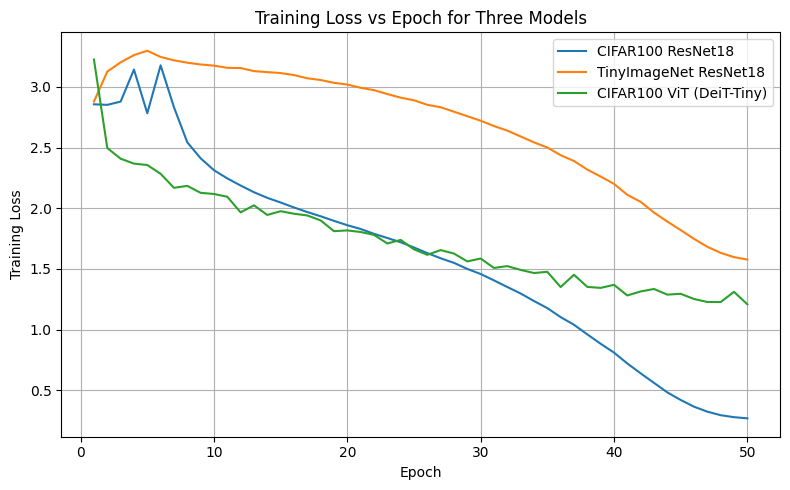

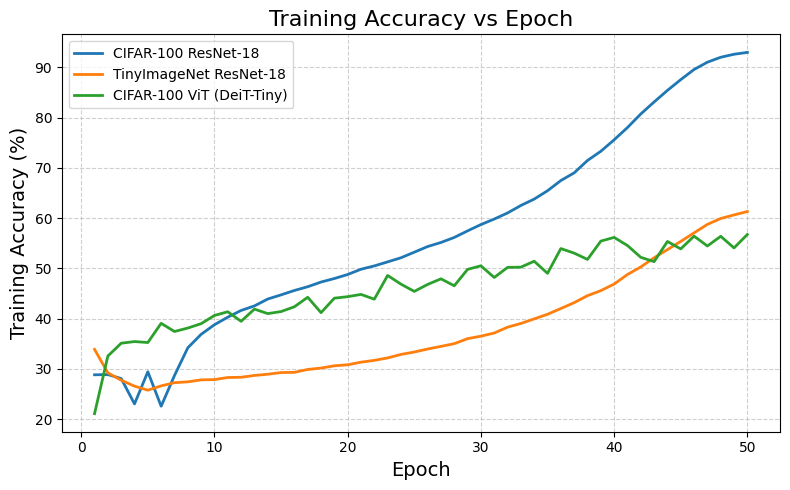

In [10]:
import re
import matplotlib.pyplot as plt

# Regex to extract epoch, train loss, val loss, train acc, val acc
line_re = re.compile(
    r"Epoch \[(\d+)/\d+\]\s*Train Loss:\s*([0-9.]+)\s*\|\s*Train Acc:\s*([0-9.]+)%\s*Val Loss:\s*([0-9.]+)\s*\|\s*Val Acc:\s*([0-9.]+)%"
)

def parse_log(log_text):
    epochs = []
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for m in line_re.finditer(log_text):
        e = int(m.group(1))
        tl = float(m.group(2))
        ta = float(m.group(3))
        vl = float(m.group(4))
        va = float(m.group(5))

        epochs.append(e)
        train_loss.append(tl)
        val_loss.append(vl)
        train_acc.append(ta)
        val_acc.append(va)

    return {
        "epoch": epochs,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc,
    }

# Parse all three logs
hist_cifar_resnet = parse_log(cifar_resnet_log)
hist_tiny_resnet  = parse_log(tiny_resnet_log)
hist_cifar_vit    = parse_log(cifar_vit_log)

print("CIFAR ResNet epochs parsed:", len(hist_cifar_resnet["epoch"]))
print("Tiny ResNet epochs parsed:", len(hist_tiny_resnet["epoch"]))
print("CIFAR ViT epochs parsed:", len(hist_cifar_vit["epoch"]))

# === 2) Plot training loss vs epoch for all three runs ===
plt.figure(figsize=(8, 5))

plt.plot(hist_cifar_resnet["epoch"], hist_cifar_resnet["train_loss"], label="CIFAR100 ResNet18")
plt.plot(hist_tiny_resnet["epoch"],  hist_tiny_resnet["train_loss"],  label="TinyImageNet ResNet18")
plt.plot(hist_cifar_vit["epoch"],    hist_cifar_vit["train_loss"],    label="CIFAR100 ViT (DeiT-Tiny)")

plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epoch for Three Models")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,5))

plt.plot(hist_cifar_resnet["epoch"],
         hist_cifar_resnet["train_acc"],
         label="CIFAR-100 ResNet-18", linewidth=2)

plt.plot(hist_tiny_resnet["epoch"],
         hist_tiny_resnet["train_acc"],
         label="TinyImageNet ResNet-18", linewidth=2)

plt.plot(hist_cifar_vit["epoch"],
         hist_cifar_vit["train_acc"],
         label="CIFAR-100 ViT (DeiT-Tiny)", linewidth=2)

plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Training Accuracy (%)", fontsize=14)
plt.title("Training Accuracy vs Epoch", fontsize=16)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


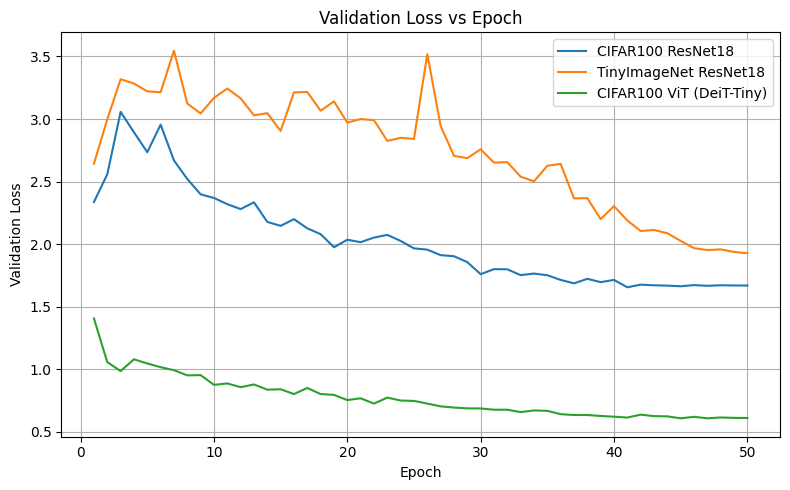

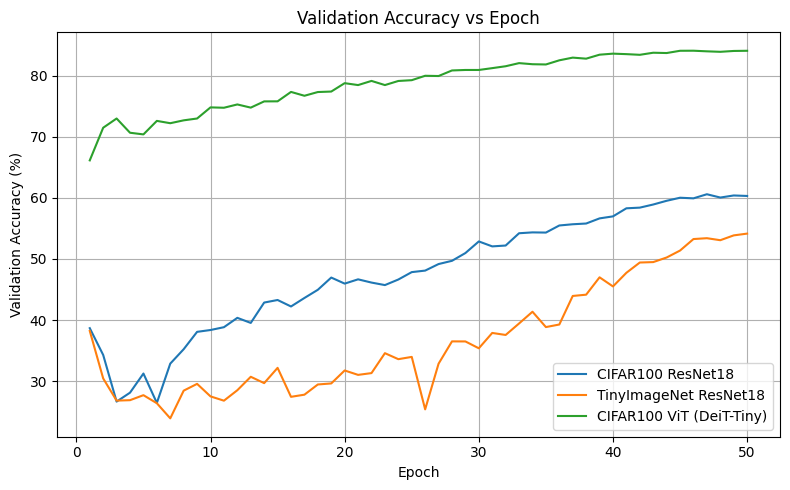

In [6]:
# Validation loss
plt.figure(figsize=(8, 5))
plt.plot(hist_cifar_resnet["epoch"], hist_cifar_resnet["val_loss"], label="CIFAR100 ResNet18")
plt.plot(hist_tiny_resnet["epoch"],  hist_tiny_resnet["val_loss"],  label="TinyImageNet ResNet18")
plt.plot(hist_cifar_vit["epoch"],    hist_cifar_vit["val_loss"],    label="CIFAR100 ViT (DeiT-Tiny)")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(hist_cifar_resnet["epoch"], hist_cifar_resnet["val_acc"], label="CIFAR100 ResNet18")
plt.plot(hist_tiny_resnet["epoch"],  hist_tiny_resnet["val_acc"],  label="TinyImageNet ResNet18")
plt.plot(hist_cifar_vit["epoch"],    hist_cifar_vit["val_acc"],    label="CIFAR100 ViT (DeiT-Tiny)")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## **Hyperparameter Exploration**

###Cifar100 with Resnet18 vs Cifar100 with Visual Transformer.

Resnet18
<ul>
<li>Starts at 38.67% val acc (epoch 1).
<li>Spends a long time in the 30–40% range (epochs 1–12).</li>
<li>Crosses 50% val acc at epoch 29–30.</li>
<li>Slowly climbs to ~60.6% best val acc by the end (epoch 47).</li>
<li>Final train acc: 92.95%</li>
<li>Gap ≈ 32–33 percentage points</li>
</ul>

Visual Transformer
<ul>
<li>Starts at 66.12% val acc (epoch 1).</li>
<li>Hits ~72–73% by epoch 3–4.</li>
<li>Hits ~80% around epoch 28–30</li>
<li>Ends at 84.06% best val acc (epoch 46)</li>
<li>Final train acc: ~56–57% (Note: Underestimate from MixUp + CutMix)</li>
<li>More important is Val loss: drops from 1.40 → ~0.61</li>
</ul>

<br>

**Evaluation and Analysis:**

Here, The same dataset is compared with two different architecture, ResNet18 and Visual Transformer (a.k.a ViT). Batch size, Epoch, and the number workers are the same to give a good comparision. For convergence, the *Visual Tranformer* **converges much faster and to a much higher level** than *ResNet-18* on the same data and number of epochs. As for generalization, *ResNet-18* reaches about **93% training accuracy but only  about 60%** validation accuracy, which indicates substantial overfitting. Further, the Resnet18 learning was slower and noisy while Visual Transformer is smoother and more consistent. The only different parameters for the two datasets are the optimizers. With ResNet18, I used SGD. With ViT, I used AdamW. This example, highlights the compatiability of optimizers as AdamW with other regulations combined to create a better results than the SGD. Further SGDs are more suited for CNNs and AdamW is perfectly suited for Transformers.

<br>

### Cifar100 with Resnet18 vs Tiny ImageNet with Resnet18.

Cifar100
<ul>
<li>Starts at 38.67% val acc.
<li>Spends a long time in the 30–40% range (epochs 1–12).</li>
<li>Crosses 50% val acc at epoch 29–30.</li>
<li>Slowly climbs to about 60.6% best val acc by the end (epoch 47).</li>
<li>Final train acc: 92.95%</li>
<li>Gap ≈ 32–33 percentage points</li>
</ul>

Tiny ImageNet
<ul>
<li>Starts at 38.2% val acc.
<li>Drops to 26–32% for many early epochs (epochs 2–15)</li>
<li>Crosses 40% around epoch 37</li>
<li>Reaches about 54% by epoch 50</li>
<li>Final train acc: 61.30%%</li>
<li>Gap ≈ 7% percentage points</li>
</ul>

**Evaluation and Analysis:**

From comparing the same architecture on different datasets, we were able to get that convergence speed of Cifar100 is quick compared to Tiny Imagenet. In the case of generalization we actually got opposite results from the two datasets, **Cifar100 overfits with a gap of 33%** while **Tiny ImageNet has a far better generalization, but somewhat underfits.** Further while it has more classes and higher resolution, the final accuracies are not that different (about a 6% difference). This suggests that the **model is capacity-limited on Tiny ImageNet with ResNet18** which limits the maximum accuracy. The stability of Cifar100 also becomes smooth after 10 epochs while Tiny ImageNet is more varied until it reaches about 30 epochs, where it starts to smooth out. All of the data concludes that Resnet18 overfits or underfits the two datasets provided. This result demonstrates that the same architecture can overfit a simpler dataset and underfit a more complex one, revealing the importance of matching model capacity to dataset complexity.